# Lab 09: Evaluating Models

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

In the previous sections, we learned to build regression models. In this section, we will learn one way to evaluate the quality of a regression model: the training error. We will also discuss the shortcomings of using training error to measure the quality of a regression model.

In [1]:
# first, mount your google drive, change to the course folder, pull latest changes, and change to the lab folder.
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cmps3160
!git pull
%cd _labs/Lab09

Mounted at /content/drive
/content/drive/My Drive/cmps3160
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/nmattei/cmps3160
   ff758d1..dfa5ca9  master     -> origin/master
Updating ff758d1..dfa5ca9
Fast-forward
 _labs/Lab09/Lab09.ipynb | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
/content/drive/My Drive/cmps3160/_labs/Lab09


In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("../data/ames.tsv", sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


## Part 1: Performance Metrics for Regression Models

To evaluate the performance of a regression model, we compare the predicted labels from the model against the true labels. Since the labels are quantitative, it makes sense to look at the difference between each predicted label $\hat y_i$ and the true label $y_i$. 

One way to make sense of these differences is to square each difference and average the squared differences. This measure of error is known as **mean squared error** (or **MSE**, for short):

$$ 
\begin{align*}
\textrm{MSE} &= \textrm{mean of } (y_i - \hat y_i)^2.
\end{align*}
$$ 

MSE is difficult to interpret because its units are the square of the units of $y$. To make MSE more interpretable, it is common to take the _square root_ of the MSE to obtain the **root mean squared error** (or RMSE, for short):

$$ 
\begin{align*}
\textrm{RMSE} &= \sqrt{\textrm{MSE}}.
\end{align*}
$$ 

The RMSE measures how off a "typical" prediction is. Notice that the reasoning above is exactly the same reasoning that we used in the early labs when we defined the variance and the standard deviation.

Another common measure of error is the **mean absolute error** (or **MAE**, for short):

$$ 
\begin{align*}
\textrm{MAE} &= \textrm{mean of } |y_i - \hat y_i|.
\end{align*}
$$ 

Like the RMSE, the MAE measures how off a "typical" prediction is. There are other metrics that can be used to measure the quality of a regression model, but these are the most common ones.

### Training Error

To calculate the MSE, RMSE, or MAE, we need data where the true labels are known. Where do we find such data? One natural source of labeled data is the training data, since we needed the true labels to be able to train a model.

For a $k$-nearest neighbors model, the training data is the data from which the $k$-nearest neighbors are selected. So to calculate the training RMSE, we do the following:

For each observation in the training data:
1. Find its $k$-nearest neighbors in the training data.
2. Average the labels of the $k$-nearest neighbors to obtain the predicted label.
3. Subtract the predicted label from the true label.

At this point, we can average the square of these differences to obtain the MSE or average their absolute values to obtain the MAE.

Let's calculate the training MSE for a 10-nearest neighbors model for house price using a subset of features from the Ames housing data set. First, we extract the variables that we need.

In [3]:
# Features in our model. All quantitative, except Neighborhood.
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]

X_train_dict = housing[features].to_dict(orient="records")
y_train = housing["SalePrice"]

Now we will use Scikit-Learn to preprocess the features...

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

...and to fit the $k$-nearest neighbors model to the data.

In [5]:
from sklearn.neighbors import KNeighborsRegressor

# Fit a 10-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train_sc, y_train)

# Calculate the model predictions on the training data.
y_train_pred = model.predict(X_train_sc)
y_train_pred

array([164090. , 131512.5, 154860. , ..., 128530. , 140600. , 201800. ])

Now it's time to compare these predictions to the true labels, which we know, since this is the training data.

In [6]:
# Calculate the mean-squared error.
mse = ((y_train - y_train_pred) ** 2).mean()
mse

1139928809.3893106

This number is very large and not very interpretable (because it is in units of "dollars squared"). Let's take the square root to obtain the RMSE.

In [7]:
rmse = np.sqrt(mse)
rmse

33762.83177385023

The RMSE says that our model's predictions are, on average, off by about \$33,000. This is not great, but it is also not too bad when an average house is worth about \$180,000.

### The Problem with Training Error

Training error is not a great measure of the quality of a model. To see why, consider a 1-nearest neighbor regression model. Before you read on, can you guess what the training error of a 1-nearest neighbor regression model will be?

In [8]:
# Fit a 1-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X_train_sc, y_train)

# Calculate the model predictions on the training data.
y_train_pred = model.predict(X_train_sc)

# Calculate the MAE
(y_train - y_train_pred).abs().mean()

24.8259385665529

The training error of this model seems too good to be true. Can our model really be off by just \$57.85 on average?

The error is so small because the nearest neighbor to any observation in the training data will be the observation itself! In fact, if we look at the vector of differences between the true and predicted labels, we see that most of the differences are zero.

In [9]:
y_train - y_train_pred

0       0.0
1       0.0
       ... 
2928    0.0
2929    0.0
Name: SalePrice, Length: 2930, dtype: float64

Why isn't the MSE exactly equal to 0, then? That is because there may be multiple houses in the training data with the exact same values for all of the features, so there may be multiple observations that are a distance of 0.0 away. Any one of these observations has equal claim to being the "1-nearest neighbor". If we happen to select one of the _other_ houses in the training data as the nearest neighbor, then its price will in general be different.

How many predictions did the 1-nearest neighbor model get wrong?

In [10]:
(y_train != y_train_pred).sum()

10

The 1-nearest neighbor model nailed the price exactly for all but 22 of the 2930 houses, so the training error is small.

Of course, a 1-nearest neighbor is unlikely to be the best model for predicting house prices. If one house in the training data happened to cost \$10,000,000, it would not be sensible to predict another house to cost \$10,000,000 -- even one very similar to it. This is why we usually average over multiple neighbors (i.e., $k$ neighbors) to make predictions.  

In the next section, we will learn a better way to measure the quality of a model than training error.

### Part 1: Exercises

#### Exercise 1

Using the Tips data set (`../data/tips.csv`), train $k$-nearest neighbors regression models to predict the tip for different values of $k$. Calculate the training MAE of each model and make a plot showing this training error as a function of $k$.

What do you see? Is there an issue here?

**Note that for this part you should only use the training MAE!**

[[1, 0.0], [2, 0.49182377049180326], [3, 0.5894945355191256], [4, 0.6194467213114754], [5, 0.6466803278688525], [6, 0.6880806010928961], [7, 0.7134074941451991], [8, 0.7165778688524591], [9, 0.7279417122040074], [10, 0.7485983606557378], [11, 0.7671721311475411], [12, 0.7787875683060108], [13, 0.7963524590163934], [14, 0.8057084309133489], [15, 0.8152295081967214], [16, 0.8249001024590163], [17, 0.8327724204435872], [18, 0.8421174863387978], [19, 0.8411712683347712], [20, 0.8452438524590162], [21, 0.8446896955503511], [22, 0.8388319672131148], [23, 0.8437615823235922], [24, 0.8481437841530055], [25, 0.8451016393442622], [26, 0.8475709331651955], [27, 0.8511035215543412], [28, 0.8539095433255268], [29, 0.8560330695308082], [30, 0.8565901639344264], [31, 0.8580380750925437], [32, 0.8604098360655738], [33, 0.8596969696969696], [34, 0.8623203953712633], [35, 0.8671229508196721], [36, 0.8683310564663023], [37, 0.8734980062029243], [38, 0.879525452976704], [39, 0.8756841109709962], [40, 0.87

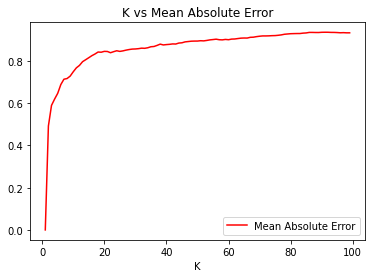

In [11]:
import matplotlib as plt
tips = pd.read_csv("../data/tips.csv")

# Separate data into features and values, and convert to dictionary vectors
features = ["total_bill", "sex", "smoker", "day", "time", "size"]
X_train_dict = tips[features].to_dict(orient="records")
y_train = tips["tip"]

# Preprocessing (dict vectors to onehot, and scale data using standardscaler)
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

mae_data = []


# Generate MAE for all points
# Assumes entire set is training data
for i, k in enumerate(range(1,100)):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train_sc, y_train)
  knn_pred = knn.predict(X_train_sc)
  mae = (y_train - knn_pred).abs().mean()
  mae_data.append([k, mae])


print(mae_data)

mae_data_df = pd.DataFrame(mae_data, columns = ["K", "Mean Absolute Error"])
mae_data_df.plot(x = "K", y = "Mean Absolute Error", color = "red", title = "K vs Mean Absolute Error")









**As K increases, the MAE actually increases and seems to converge to 1 - higher K for KNN regression doesn't actually reduce in lower training error**

## Part 2: Test and Validation Errors

In the previous section, we saw that training error is not a great measure of a model's quality. For example, a $1$-nearest neighbor model will have a training error of $0.0$ (or close to it), but it is not necessarily the best prediction model, especially if there are outliers in the training data.

In order to come up with a better measure of model quality, we need to formalize what it is we want to measure.

In [12]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("../data/ames.tsv", sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


### Overfitting and Test Error

Ultimately, the goal of any prediction model is to make predictions on _future_ data. Therein lies the problem with training error. Training error measures how well a model predicts on the current data. It is possible to build a model that **overfits** to the training data---that is, a model that fits so well to the current data that it does poorly on future data.

For example, consider fitting two different models to the 10 training observations shown below. The model represented by the red line actually passes through every observation (that is, its training error is zero). However, most people would prefer the model represented by the blue line. If one had to make a prediction for $y$ when $x = 0.8$, the value of the blue line is intuitively more plausible than the value of the red line, which is out of step with the nearby points.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/overfitting.png?raw=1)

The argument for the blue model depends on _future_ data because the blue model is actually worse than the red model on the current data. The red model tries so hard to get the predictions on the training data right that it ends up _overfitting_.

If the goal is to build a model that performs well on future data, then we ought to evaluate it (i.e., by calculating MSE, MAE, etc.) on future data. The prediction error on future data is also known as **test error**, in contrast to training error, which is the prediction error on current data. To calculate the test error, we need _labeled_ future data. In many applications, future data is expensive to collect and _labeled_ future data is even more expensive. How can we approximate the test error, using just the data that we have?

### Validation Error

The solution is to split the training data into a **training set** and a **validation set**. The model will only be fit on the observations of the training set. Then, the model will be evaluated on the validation set. Because the validation set has not been seen by the model already, it essentially plays the role of "future" data, even though it was carved out of the current data.

The prediction error on the validation set is known as the **validation error**. The validation error is an approximation to the test error.

To split our data into training and validation sets, we use the `.sample()` function in `pandas`. Let's use this to split our data into two equal halves, which we will call `train` and `val`.

In [13]:
train = housing.sample(frac=.5)
val = housing.drop(train.index)

train

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2909,2910,923225240,160,RM,41.0,2665,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,127000
847,848,907192090,20,RL,67.0,9808,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,227000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,2171,908127040,20,RL,73.0,10921,Pave,NaN,Reg,HLS,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,94750
2262,2263,916384150,20,RL,89.0,10991,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,239000


Now let's use this training/validation split to approximate the test error of a 10-nearest neighbors model.

First, we extract the variables we need.

In [14]:
# Features in our model. All quantitative, except Neighborhood.
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]

X_train_dict = train[features].to_dict(orient="records")
X_val_dict = val[features].to_dict(orient="records")

y_train = train["SalePrice"]
y_val = val["SalePrice"]

Next, we use Scikit-Learn to preprocess the training and the validation data. Note that the vectorizer and the scaler are both fit to the training data, so we learn the categories, the mean, and standard deviation from the training set---and use these to transform both the training and validation sets.

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

# convert categorical variables to dummy variables
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
X_val = vec.transform(X_val_dict)

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)

We are now ready to fit a $k$-nearest neighbors model to the training data.

In [16]:
from sklearn.neighbors import KNeighborsRegressor

# Fit a 10-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train_sc, y_train)

KNeighborsRegressor(n_neighbors=10)

We make predictions on the validation set and calculate the validation RMSE:

In [17]:
y_val_pred = model.predict(X_val_sc)
rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())
rmse

42509.62507015439

Notice that the test error is higher than the training error that we calculated in the previous section. In general, this will be true. It is harder for a model to predict for new observations it has not seen, than for observations it has seen!

### Cross Validation

One downside of the validation error above is that it was calculated using only 50% of the data. As a result, the estimate is noisy.

There is a cheap way to obtain a second opinion of how well our model will do on future data. Previously, we split our data at random into two halves, training the model on the first half and evaluating it using the second half. Because the model has not already seen the second half of the data, this approximates how well the model would perform on future data. 

But the way we split our data was arbitrary. We might as well swap the roles of the two halves, training the model on the _second_ half and evaluating it using the _first_ half. As long as the model is always evaluated on data that is different from the data that was used to train it, we have a valid measure of how well our model would perform on future data. A schematic of this approach, known as **cross-validation**, is shown below.

<img src="https://github.com/nmattei/cmps3160/blob/master/_labs/images/cross-validation.png?raw=1" />

Because we will be doing all computations twice, just with different data, let's wrap the $k$-nearest neighbors algorithm above into a function called `get_val_error()`, that computes the validation error given training and validation data.

In [18]:
def get_val_error(X_train, y_train, X_val, y_val):
    
    # convert categorical variables to dummy variables
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_val = vec.transform(X_val_dict)

    # standardize the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc = scaler.transform(X_val)
    
    # Fit a 10-nearest neighbors model.
    model = KNeighborsRegressor(n_neighbors=10)
    model.fit(X_train_sc, y_train)
    
    # Make predictions on the validation set.
    y_val_pred = model.predict(X_val_sc)
    rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())
    
    return rmse

If we apply this function to the training and test sets from earlier, we get the same estimate of the test error.

In [19]:
get_val_error(X_train, y_train, X_val, y_val)

42509.62507015439

But if we reverse the roles of the training and test sets, we get another estimate of the test error.

In [20]:
get_val_error(X_val, y_val, X_train, y_train)

81458.1462016037

Now we have two, somewhat independent estimates of the test error. It is common to average the two to obtain an overall estimate of the test error, called the **cross-validation error**. Notice that the cross-validation error uses each observation in the data exactly once. We make a prediction for each observation, but always using a model that was trained on data that does not include that observation.

### Part 2: Exercises

#### Exercise 2

Use cross-validation to estimate the test error of a 1-nearest neighbor classifier on the Ames housing price data. How does a 1-nearest neighbor classifier compare to a 10-nearest neighbor classifier in terms of its ability to predict on _future_ data?

In [21]:
housing = pd.read_csv("../data/ames.tsv", sep="\t")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]

# Get dummies for X, split off sale-price for label parameter
X = pd.get_dummies(housing[features])
y = housing["SalePrice"]

# Split data in half
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

# KNN Regressors for n = 1, 10
KNN1 = KNeighborsRegressor(n_neighbors = 1)
KNN10 = KNeighborsRegressor(n_neighbors = 10)

# Scale then fit models
knn1pipe = Pipeline([('scaler', StandardScaler()), ('knn1', KNN1)])
knn1pipe.fit(X_train, y_train)

knn10pipe = Pipeline([('scaler', StandardScaler()), ('knn10', KNN10)])
knn10pipe.fit(X_train, y_train)

# Cross validate on one 'fold' - returns "score", not "error"
knn1_cv_results = cross_validate(knn1pipe, X, y, cv = 2, scoring = "neg_root_mean_squared_error")
print(knn1_cv_results)
knn10_cv_results = cross_validate(knn10pipe, X, y, cv = 2, scoring = "neg_root_mean_squared_error")
print(knn10_cv_results)
print()


# Output mean of CV scores for each model
print("1 Neighbor RMSE: %.4f error" %(-knn1_cv_results["test_score"].mean()))
print("10 Neighbor RMSE: %.4f error"%(-knn10_cv_results["test_score"].mean()))





{'fit_time': array([0.00732732, 0.01249456]), 'score_time': array([0.04295635, 0.05505586]), 'test_score': array([-44449.82396063, -47056.22528941])}
{'fit_time': array([0.01070499, 0.01049781]), 'score_time': array([0.06017256, 0.06464696]), 'test_score': array([-43747.34203993, -47980.87905043])}

1 Neighbor RMSE: 45753.0246 error
10 Neighbor RMSE: 45864.1105 error


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

housing = pd.read_csv("../data/ames.tsv", sep="\t")
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]

X_dict = housing[features].to_dict(orient="records")
y = housing["SalePrice"]

testMAE = []

for i,k in enumerate([1,10]):
  # Create KNN Model
  knn_model = KNeighborsRegressor(n_neighbors = k)
  # Create pipeline with KNN, scaler, vectorizer
  pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", knn_model)])
  # Get cross-val scores (accuracy) for pipeline  cv = 2
  mae = cross_validate(pipeline, X_dict, y, cv = 2, scoring = "neg_mean_absolute_error", return_train_score = False)
  # Extract error (1 - (-MAE_score))
  test_mae = np.mean(mae["test_score"])
  # Append data to array
  testMAE.append([k,test_mae])

testMAE_df = pd.DataFrame(testMAE, columns = ["K", "Test MAE"])
testMAE_df.set_index(["K"], inplace = True)
testMAE_df.head()




,Test MAE
K,
1,-30162.499317
10,-30052.833447


*The 10-neighbor model is slightly worse at predicting future data than the 1-neighbor model, which implies that it is slightly overfit*

#### Exercise 3

Using the Tips data set (`../data/tips.csv`), train $k$-nearest neighbors regression models to predict the tip for different values of $k$. Calculate the training and validation MAE of each model, and make a plot showing these errors as a function of $k$.

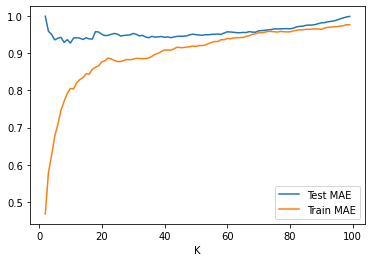

In [83]:
import matplotlib as plt

# Load data, separate features
tips = pd.read_csv("../data/tips.csv")
features = ["total_bill", "sex", "smoker", "day", "time", "size"]
X_dict = tips[features].to_dict(orient="records")
y = tips["tip"]

# Load vectorizer, scaler
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

# Array for error data
error1data = []

# For k in between 2 and 100
for i, k in enumerate(range(2,100)):
  # Create KNN Model
  knn_model = KNeighborsRegressor(n_neighbors = k)
  # Create pipeline with KNN, scaler, vectorizer
  pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", knn_model)])
  # Get cross-val scores (accuracy) for pipeline and return training score as well, cv = 2 (1 fold)
  mae = cross_validate(
        pipeline, X_dict, y, 
        cv=2, scoring="neg_mean_absolute_error", return_train_score = True)
  # Extract error values
  test_mae = np.mean(-mae["test_score"])
  train_mae = np.mean(-mae["train_score"])
  # Append data to array
  error1data.append([k, test_mae, train_mae])

# Plot data
error1_df = pd.DataFrame(error1data, columns = ["K", "Test MAE", "Train MAE"])
error1_df.set_index(["K"], inplace = True)
error1_df.plot()


  

**Written Answer:**
*Just the plot?*

## Part 3: Bringing It All Together: Model Selection and Hyperparameter Tuning

This section will use the tools developed in the previous section to answer two important questions:

- Model Selection: How do we determine which model is best?
- Hyperparameter Tuning: How do we choose hyperparameters, such as $k$ in $k$-nearest neighbors?

In the previous section, we saw how to use training and validation sets to estimate how well the model will perform on future data. A natural way to decide between competing models (or hyperparameters) is to choose the one that minimizes the validation error.

In [23]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("../data/ames.tsv", sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


### $K$-Fold Cross Validation

Previously, we carried out cross validation by splitting the data into 2 halves, alternately using one half to train the model and the other to evaluate the model. In general, we can split the data into $k$ subsamples, alternately training the data on $k-1$ subsamples and evaluating the model on the $1$ remaining subsample, i.e., the validation set. This produces $k$ somewhat independent estimates of the test error. This procedure is known as **$k$-fold cross validation**. (Be careful not to confuse the $k$ in $k$-fold cross validation with the $k$ in $k$-nearest neighbors.) Therefore, the specific version of cross validation that we saw earlier is $2$-fold cross validation.

A schematic of $4$-fold cross validation is shown below.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/k-folds.png?raw=1)

Implementing $k$-fold cross validation from scratch for $k > 2$ is straightforward but messy, so we will usually let Scikit-Learn do it for us.

### Cross Validation in Scikit-Learn

Scikit-Learn provides a function, `cross_val_score`, that will carry out all aspects of $k$-fold cross validation: 

1. split the data into $k$ subsamples
2. combine the first $k-1$ subsamples into a training set and train the model
3. evaluate the model predictions on the last ($k$th) held-out subsample
4. repeat steps 2-3 $k$ times (i.e. $k$ "folds"), each time holding out a different one of the $k$ subsamples
4. calculate $k$ "scores", one from each validation set

There is one subtlety to keep in mind. Training a $k$-nearest neighbors model is not just about fitting the model; it also involves dummifying the categorical variables and scaling the variables. These preprocessing steps should be included in the cross-validation process. They cannot be done ahead of time.

For example, suppose we run $5$-fold cross validation. Then:

- When subsamples 1-4 are used for training and subsample 5 for validation, the observations have to be standardized with respect to the mean and SD of subsamples 1-4.
- When subsamples 2-5 are used for training and subsample 1 for validation, the observations have to be standardized with respect to the mean and SD of subsamples 2-5.
- And so on.

We cannot simply standardize all of the data once at the beginning and run cross validation on the standardized data. To do so would be allowing the model to peek at the validation set during training. That's because each training set would be standardized with respect to a mean and SD that is calculated from all data, including the validation set. To be completely above board, we should standardize each training set with respect to the mean and SD of just that training set.

Fortunately, Scikit-Learn provides a `Pipeline` object that allows us to chain these preprocessing steps together with the model we want to fit.

In [24]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

# get the features (in dict format) and the labels
# (do not split into training and validation sets)
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]
X_dict = housing[features].to_dict(orient="records")
y = housing["SalePrice"]

# specify the pipeline
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=10)
pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])

This entire `Pipeline` can be passed to `cross_val_score`, along with the data, the number of folds $k$ (`cv`), and the type of score (`scoring`). So $5$-fold cross validation in Scikit-Learn would look as follows:

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_dict, y, 
                         cv=5, scoring="neg_mean_squared_error")
scores

array([-1.98025092e+09, -1.47911560e+09, -1.54635484e+09, -1.87653695e+09,
       -1.42161575e+09])

Notice that we get five (negative) validation MSEs, one from each of the 5 folds. `cross_val_score` returns the _negative_ MSE, instead of the MSE, because by definition, a _higher_ score is better. (Since we want the MSE to be as _low_ as possible, we want the negative MSE to be as _high_ as possible.)

To come up with a single overall estimate of the test MSE, we flip the signs and average the MSEs:

In [26]:
np.mean(-scores)

1660774812.550652

The RMSE is the square root of the MSE:

In [27]:
np.sqrt(np.mean(-scores))

40752.60497870844

### Hyperparameter Tuning

How do we choose $k$? We can simply try all values of $k$ and pick the one with the smallest (test) MSE.

**Note:** Depending on your machine this may take a min to run..

4     1.390838e+09
3     1.405816e+09
          ...     
49    2.208812e+09
50    2.216512e+09
Length: 50, dtype: float64

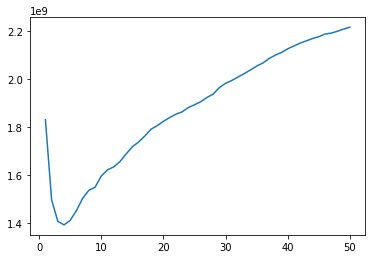

In [28]:
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

# calculates estimate of test error based on 10-fold cross validation
def get_cv_error(k):
    model = KNeighborsRegressor(n_neighbors=k)
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    mse = np.mean(-cross_val_score(
        pipeline, X_dict, y, 
        cv=10, scoring="neg_mean_squared_error"
    ))
    return mse
    
ks = pd.Series(range(1, 51))
ks.index = range(1, 51)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values()

The MSE is minimized near $k = 4$, which suggests that a $4$-nearest neighbors model is optimal for prediction.

### Model Selection

Suppose we are not sure whether `Yr Sold` should be included in the $4$-nearest neighbors model or not. To determine whether or not it should be included, we can fit a model with `Yr Sold` included and another model with it excluded, and see which model has the better (test) MSE.

In [29]:
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=4)
pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])

In [30]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]
X_dict = housing[features].to_dict(orient="records")
np.mean(
    -cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error")
)

1390838306.03189

In [31]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built",
            "Neighborhood"]
X_dict = housing[features].to_dict(orient="records")
-cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error").mean()

1315298843.187244

The MSE actually goes down when we remove `Yr Sold`, so it seems that the model is better off without this variable.

### Part 3: Exercises

#### Exercise 4

Using the Tips data set (`../data/tips.csv`), train $k$-nearest neighbors regression models to predict the tip for different values of $k$ and validate your model using 5 fold cross validation. Calculate the training and validation MAE of each model, and make a plot showing these errors as a function of $k$.

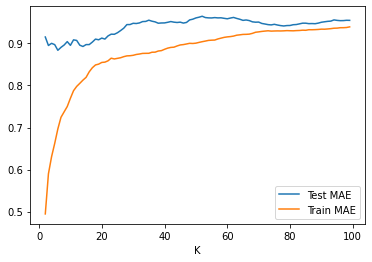

In [84]:
# Load data, separate features
tips = pd.read_csv("../data/tips.csv")
features = ["total_bill", "sex", "smoker", "day", "time", "size"]
X_dict = tips[features].to_dict(orient="records")
y = tips["tip"]

# Load vectorizer, scaler
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

# Array for error data
error1data = []

# For k in between 2 and 100
for i, k in enumerate(range(2,100)):
  # Create KNN Model
  knn_model = KNeighborsRegressor(n_neighbors = k)
  # Create pipeline with KNN, scaler, vectorizer
  pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", knn_model)])
  # Get cross-val scores (accuracy) for pipeline and return training score as well, cv = 5
  mae = cross_validate(
        pipeline, X_dict, y, 
        cv=5, scoring="neg_mean_absolute_error", return_train_score = True)
  # Extract error (1 - (- MAE_score))
  test_mae = np.mean(-mae["test_score"])
  train_mae = np.mean(-mae["train_score"])
  # Append data to array
  error1data.append([k, test_mae, train_mae])

# Plot data
error1_df = pd.DataFrame(error1data, columns = ["K", "Test MAE", "Train MAE"])
error1_df.set_index(["K"], inplace = True)
error1_df.plot()

In [85]:
print(error1_df.loc[error1_df["Test MAE"] == error1_df["Test MAE"].min()])

   Test MAE  Train MAE
K                     
6  0.883736   0.696664


**Written Question:** The best value for K is 6, with a training MAE of 0.70, and a test MAE of 0.88

#### BONUS (2 Points)

Use what we've learned about model selection to determine whether or not including the day of the week is a good feature for a model to predict tips.

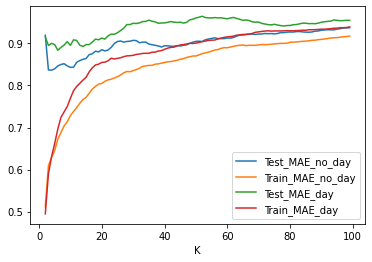

In [86]:
# Load features - do not include day and separate
features2 = ["total_bill", "sex", "smoker", "time", "size"]
X_dict = tips[features2].to_dict(orient="records")
y = tips["tip"]

# Load vectorizer, scaler
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

# Array for error data
error2data = []

# For k between 2 and 100
for i, k in enumerate(range(2,100)):
  # Create knn model
  knn_model = KNeighborsRegressor(n_neighbors = k)
  # Create pipeline with vectorizer, scaler, knn
  pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", knn_model)])
  # Get cross-val scores (accuracy) for pipeline and return training score as well, cv = 5
  mae = cross_validate(
        pipeline, X_dict, y, 
        cv=5, scoring="neg_mean_absolute_error", return_train_score = True)
  # Extract error 
  test_mae = np.mean(-mae["test_score"])
  train_mae = np.mean(-mae["train_score"])
  # Append data to array
  error2data.append([k, test_mae, train_mae])


# Create frame of error
error2_df = pd.DataFrame(error2data, columns = ["K", "Test MAE", "Train MAE"])
error2_df.set_index(["K"], inplace = True)

# Plot both sets of error, compare
combined_error = error2_df.join(error1_df, how = "inner", on = ["K"], lsuffix = "_noday", rsuffix = "_wday")
combined_error.columns = ["Test_MAE_no_day", "Train_MAE_no_day", "Test_MAE_day", "Train_MAE_day"]
combined_error.plot()


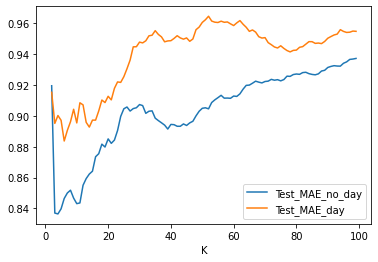

In [87]:
# Plot just Test MAE
combined_error_test = combined_error[["Test_MAE_no_day", "Test_MAE_day"]]
combined_error_test.plot()

**Written Question:** Should we include day of the week?  Show a graph and values to show why or why not.


*'day' should not be included, since in the best case scenario, the test and training MAE are both lower, so removing it results in a more accurate model. See below - the only value for K where not including the day results in a higher MAE is when k = 2 - despite being only a marginal difference, the training error when k = 2 is still massive. For all other instances, removing the day results in a lower test MAE*




In [90]:
# Print metrics
print("K such that not including day results in a worse error:")
print(combined_error_test.loc[combined_error_test["Test_MAE_no_day"] > combined_error_test["Test_MAE_day"]])
print()
print("Lowest MAE with no day value:")
print(combined_error_test.loc[combined_error_test["Test_MAE_no_day"] == combined_error_test["Test_MAE_no_day"].min()])
print()
print("Lowest MAE with day value:")
print(combined_error_test.loc[combined_error_test["Test_MAE_day"] == combined_error_test["Test_MAE_day"].min()])

K such that not including day results in a worse error:
   Test_MAE_no_day  Test_MAE_day
K                               
2         0.919601      0.915341

Lowest MAE with no day value:
   Test_MAE_no_day  Test_MAE_day
K                               
4         0.836417      0.900274

Lowest MAE with day value:
   Test_MAE_no_day  Test_MAE_day
K                               
6         0.846452      0.883736


### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)